In [ ]:
import pandas as pd
import numpy as np

# modeling
import keras
from keras.utils import pad_sequences
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

2025-02-19 16:24:50.698331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Expects: run the code on lstm_traffic_only_1 to generate the csv info
traffic_df = pd.read_csv("../data/traffic_pre_lstm.csv")
traffic_df['timestamp'] = pd.to_datetime(traffic_df['timestamp'])
traffic_df.set_index('timestamp', inplace=True)
traffic_df.head()

,610,611,612,613,614,615,616,617,618,619,...,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-01 08:10:00,41.0,0.0,52.0,38.0,40.0,86.0,62.0,44.0,40.0,23.0,...,16.0,20.0,21.0,50.0,19.0,48.0,34.0,0.0,65.0,32.000000
2014-08-01 08:15:00,41.0,0.0,52.0,40.0,40.0,86.0,62.0,45.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,69.0,34.0,0.0,69.0,32.000000
2014-08-01 08:20:00,41.0,0.0,61.0,44.0,40.0,33.0,75.0,49.0,40.0,23.0,...,16.0,35.0,21.0,50.0,21.0,70.0,36.0,0.0,67.0,28.000000
2014-08-01 08:25:00,41.0,0.0,61.0,45.0,40.0,33.0,59.0,53.0,44.0,23.0,...,22.0,37.0,21.0,57.0,22.0,56.0,46.0,0.0,58.0,28.000000
2014-08-01 08:30:00,41.0,0.0,38.0,43.0,40.0,77.0,59.0,47.0,36.0,23.0,...,22.0,23.0,14.0,57.0,22.0,51.0,46.0,0.0,60.0,27.666667


In [4]:
traffic_df.shape

(29984, 449)

In [ ]:
def create_sequence_training_set(training_sample, seq_length, pred_horizon, input_features, output_features):
    seq_arrays = []
    seq_labs = []

    for i in range(training_sample.shape[0] - seq_length - pred_horizon):
        seq_arrays.append(
            training_sample.iloc[i:seq_length+i, :input_features].to_numpy())

        seq_labs.append(
            training_sample.iloc[seq_length+pred_horizon+i, :output_features])

    seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
    seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)

    return seq_arrays, seq_labs

# create validation dataset


def create_validation_set(validation_sample, seq_length, pred_horizon, input_features, output_features):
    val_arrays = []
    val_labs = []

    for i in range(validation_sample.shape[0] - seq_length - pred_horizon):
        if i < seq_length:
            val_arrays.append(
                validation_sample.iloc[:(i+1), :input_features].to_numpy())

            val_labs.append(validation_sample.iloc[:(
                i+pred_horizon+1), :output_features].to_numpy()[-1])
        else:
            val_arrays.append(
                validation_sample.iloc[i:seq_length+i, :input_features].to_numpy())

            val_labs.append(
                validation_sample.iloc[seq_length+i+pred_horizon, :output_features])

    val_arrays = pad_sequences(
        val_arrays, padding='pre', dtype=object).astype(np.float32)

    val_labs = np.array(val_labs, dtype=object).astype(np.float32)

    return val_arrays, val_labs

In [ ]:
def train_lstm_model(model_path, 
                     seq_length, 
                     seq_arrays, 
                     seq_labs, 
                     input_features, 
                     output_features):
    
    # build the network
    output_size = output_features

    model = Sequential()

    model.add(LSTM(
        input_shape=(seq_length, input_features),
        units=100, activation="relu", return_sequences=True))
    model.add(Dropout(0.025))

    model.add(LSTM(units=64, activation="relu", return_sequences=True))
    model.add(Dropout(0.025))
    model.add(LSTM(units=32, activation="relu", return_sequences=False))
    model.add(Dense(units=output_size, activation="linear"))

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer, metrics=['mse'])

    print(model.summary())

    # fit the network
    history = model.fit(seq_arrays,
                        seq_labs,
                        epochs=1000,
                        batch_size=80,
                        validation_split=0.05,
                        verbose=2,
                        callbacks=[
                            keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                min_delta=0.1,
                                patience=5,
                                verbose=0,
                                mode='min'),
                            keras.callbacks.ModelCheckpoint(
                                model_path,
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min',
                                verbose=0)
                        ])

    return model, history

In [41]:
def plot_prediction_across_network(model, val_arrays, val_labs, title):
    y_pred_test = model.predict(val_arrays)
    y_true_test = val_labs

    # aggregating for easier visualization
    y_pred_dv = [row.sum() for row in y_pred_test]
    y_true_dv = [row.sum() for row in y_true_test]

    start = 100
    ts = 1000

    plt.plot(y_pred_dv[start:start+ts], label='Predicted Value')
    plt.plot(y_true_dv[start:start+ts], label='Actual Value')
    plt.title(title,
            fontsize=22, fontweight='bold')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend()
    plt.show()

# Alternative 3: Parking information

In [30]:
parking_df = pd.read_csv("../data/aarhus_parking_geolocated.csv")
parking_df['updatetime'] = pd.to_datetime(parking_df['updatetime'])

# create a timestamp at the 5 minute interval in line with the traffic data
parking_df["timestamp"] = parking_df["updatetime"].apply(
    pd.Timestamp.ceil, freq="5min")
parking_df.set_index("timestamp", drop=True, inplace=True)

# aggregate over the timestamp
parking_df = parking_df.groupby(parking_df.index).agg({
    'vehiclecount': 'sum',
    'totalspaces': 'sum'
})

parking_df['occupancy_rate'] = parking_df['vehiclecount'] / \
    parking_df['totalspaces']

# merge with a complete timestamp index
timestamp_index = pd.DataFrame({"timestamp": pd.date_range(pd.to_datetime(
    parking_df.index.min()), pd.to_datetime(parking_df.index.max()), freq="5min").to_list()})

parking_df = timestamp_index.merge(
    parking_df,
    how="left",
    left_on="timestamp",
    right_index=True
)

# impute missing values using linear interpolation
parking_df['occupancy_rate'].interpolate("linear", inplace=True)
parking_df.set_index("timestamp", inplace=True)

parking_features = ['occupancy_rate']

combined_parking_traffic = traffic_df.merge(
    parking_df[parking_features],
    how="left",
    left_index=True,
    right_index=True
)

# remove rows at the end without occupancy data
combined_parking_traffic = combined_parking_traffic[combined_parking_traffic["occupancy_rate"].notna()]

In [31]:
combined_parking_traffic.shape

(27434, 450)

In [32]:
training_sample = combined_parking_traffic[100:17000]
validation_sample = combined_parking_traffic[17001:]

validation_sample.shape

(10433, 450)

In [33]:
# set predictive horizon and sequence length
ph = 5
seq_length = 12

# features to randomly sample without replacement
# must be a value between 1 to 450, inclusive
input_features = 450
output_features = 449

sensor = pd.Series(training_sample.columns).sample(
    input_features, replace=False).sort_values().to_list()


seq_arrays, seq_labs = create_sequence_training_set(
    training_sample, seq_length, ph, input_features, output_features)

val_arrays, val_labs = create_validation_set(
    validation_sample, seq_length, ph, input_features, output_features)

In [34]:
model, history = train_lstm_model('lstm_traffic_parking.keras',
                                  seq_length,
                                  seq_arrays,
                                  seq_labs,
                                  input_features,
                                  output_features)
# list all data in history
print(history.history.keys())

/opt/anaconda3/envs/usd_ai/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 12, 100)        │       220,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 12, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 449)            │        14,817 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,873 (1.11 MB)

 Trainable params: 289,873 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
201/201 - 8s - 42ms/step - loss: 1369.2078 - mse: 1369.2078 - val_loss: 209.6484 - val_mse: 209.6484
Epoch 2/1000
201/201 - 5s - 23ms/step - loss: 194.3494 - mse: 194.3494 - val_loss: 184.3425 - val_mse: 184.3425
Epoch 3/1000
201/201 - 5s - 23ms/step - loss: 175.4553 - mse: 175.4553 - val_loss: 184.5986 - val_mse: 184.5986
Epoch 4/1000
201/201 - 5s - 23ms/step - loss: 167.2103 - mse: 167.2103 - val_loss: 183.6235 - val_mse: 183.6235
Epoch 5/1000
201/201 - 5s - 23ms/step - loss: 167.9044 - mse: 167.9044 - val_loss: 182.1540 - val_mse: 182.1540
Epoch 6/1000
201/201 - 5s - 24ms/step - loss: 165.6464 - mse: 165.6464 - val_loss: 181.2113 - val_mse: 181.2113
Epoch 7/1000
201/201 - 5s - 24ms/step - loss: 165.0216 - mse: 165.0216 - val_loss: 178.4665 - val_mse: 178.4665
Epoch 8/1000
201/201 - 5s - 24ms/step - loss: 164.7399 - mse: 164.7399 - val_loss: 180.5041 - val_mse: 180.5041
Epoch 9/1000
201/201 - 6s - 27ms/step - loss: 168.5811 - mse: 168.5811 - val_loss: 183.0175 - val

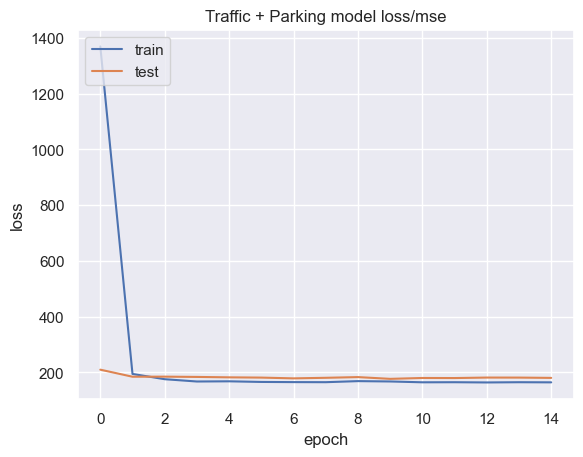

326/326 - 2s - 5ms/step - loss: 282.6927 - mse: 282.6927

MSE: 282.69268798828125


In [35]:
def summarize_history_loss(history, title):
    # summarize history for Loss/MSE
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

summarize_history_loss(history, "Traffic + Parking model loss/mse")

scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


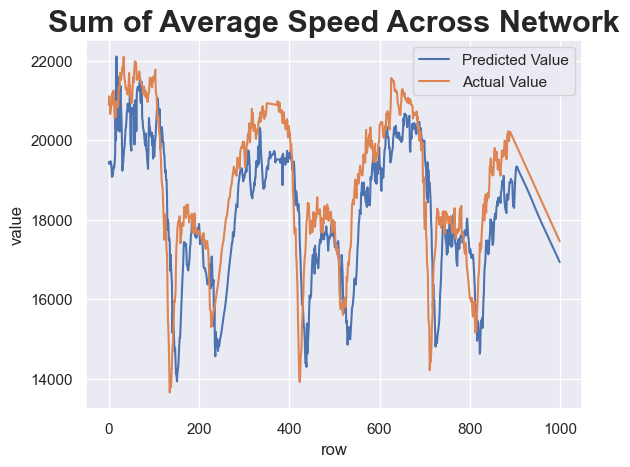

In [42]:
plot_prediction_across_network(model, val_arrays, val_labs, 'Sum of Average Speed Across Network')